In [1]:
import sys
import os

os.chdir(os.path.join(sys.path[0], '..'))
os.environ['LOGLEVEL'] = "ERROR"

In [2]:
memory_order = ["episodic", "semantic", "both", "both_presem"]

max_history = 1024

legend_order = [
    "Hand-crafted 1: Only episodic",
    "Hand-crafted 2: Only semantic",
    "Hand-crafted 3: Both epi and sem",
    "Hand-crafted 4: Both epi and pre-sem",
]

color_order = ["orange", "dodgerblue", "yellowgreen", "deeppink"]

# should be "no_random", "only_random", "episodic_forget_random" , "semantic_forget_random", 
# "episodic_answer_random", or "semantic_answer_random"
policy = "no_random"

paths = "./training-results/*/train_hand_crafted.json"


In [3]:
from memory.utils import read_json
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter
import numpy as np


In [4]:
def what_policy(config):
    policies = list(
        set(
            [
                val_
                for key, val in config["policy"].items()
                for key_, val_ in val.items()
            ]
        )
    )
    if "random" not in policies:
        return "no_random"

    if (
        config["memory_type"] != "both"
        and config["policy"][config["memory_type"]]["forget"] == "random"
        and config["policy"][config["memory_type"]]["answer"] == "random"
    ):
        return "only_random"

    if (
        config["memory_type"] == "both"
        and len(list(set(policies))) == 1
        and list(set(policies))[0] == "random"
    ):
        return "only_random"

    if (
        config["memory_type"] == "episodic"
        and config["policy"][config["memory_type"]]["forget"] == "random"
        and config["policy"][config["memory_type"]]["answer"] == "latest"
    ):
        return "episodic_forget_random"


    if (
        config["memory_type"] == "episodic"
        and config["policy"][config["memory_type"]]["forget"] == "oldest"
        and config["policy"][config["memory_type"]]["answer"] == "random"
    ):
        return "episodic_answer_random"

    if (
        config["memory_type"] == "semantic"
        and config["policy"][config["memory_type"]]["forget"] == "random"
        and config["policy"][config["memory_type"]]["answer"] == "strongest"
    ):
        return "semantic_forget_random"

    if (
        config["memory_type"] == "semantic"
        and config["policy"][config["memory_type"]]["forget"] == "weakest"
        and config["policy"][config["memory_type"]]["answer"] == "random"
    ):
        return "semantic_answer_random"

    else:
        return "somethign else"


configs = {path: read_json(path) for path in tqdm(glob(paths))}
print(f"number of configs before parsing: {len(configs)}")

configs = {
    path: config
    for path, config in configs.items()
    if config["max_history"] == max_history and what_policy(config) == policy
}
print(f"number of matching ({policy}) configs: {len(configs)}")

results_raw = {
    path: read_json(path.replace("train_hand_crafted", "results"))
    for path, config in tqdm(configs.items())
}

print(f"number of loaded results {policy}: {len(results_raw)}")


  0%|          | 0/2000 [00:00<?, ?it/s]

number of configs before parsing: 2000
number of matching (no_random) configs: 200


  0%|          | 0/200 [00:00<?, ?it/s]

number of loaded results no_random: 200


In [5]:
results = {key: [] for key in memory_order}
seeds = []
capacities = []
for key, result in results_raw.items():
    memory_type = result["memory_type"]
    capacity = result["capacity"]["episodic"] + result["capacity"]["semantic"]
    rewards = {split: result[split]["rewards"] for split in ["train", "val", "test"]}

    seed = result["seed"]
    seeds.append(seed)
    capacities.append(capacity)

    to_append = {"capacity": capacity, "rewards": rewards, "seed": seed}

    if result["memory_type"] == "episodic":
        results["episodic"].append(to_append)
    elif result["memory_type"] == "semantic":
        results["semantic"].append(to_append)
    elif result["memory_type"] == "both" and (not result["pretrain_semantic"]):
        results["both"].append(to_append)
    elif result["memory_type"] == "both" and (result["pretrain_semantic"]):
        results["both_presem"].append(to_append)
    else:
        raise ValueError

assert len(set(list((dict(Counter(seeds)).values())))) == 1
seeds = set(seeds)

print("before averaging seeds:")
for key, val in results.items():
    print(key, len(val))

capacities = sorted(list(set(capacities)))


def rewards2acc(rewards):
    return {key: val / max_history for key, val in rewards.items()}


def get_mean_std(list_of_accs):
    nums = {
        split: [acc[split] for acc in list_of_accs]
        for split in ["train", "val", "test"]
    }
    means = {split: np.mean(nums[split]) for split in ["train", "val", "test"]}
    stds = {split: np.std(nums[split]) for split in ["train", "val", "test"]}
    num_samples = {split: len(nums[split]) for split in ["train", "val", "test"]}

    return {"means": means, "stds": stds, "num_samples": nums}


results = {
    key: {
        capacity: get_mean_std(
            [
                rewards2acc(val_["rewards"])
                for val_ in val
                if val_["capacity"] == capacity
            ]
        )
        for capacity in capacities
    }
    for key, val in results.items()
}


before averaging seeds:
episodic 50
semantic 50
both 50
both_presem 50


episodic [0.0251953125, 0.0453125, 0.0796875, 0.140625, 0.2400390625, 0.3939453125, 0.6044921875, 0.821484375, 0.967578125, 1.0]
semantic [0.0119140625, 0.05546875, 0.0693359375, 0.1333984375, 0.2271484375, 0.37734375, 0.5021484375, 0.53359375, 0.539453125, 0.5359375]
both [0.0314453125, 0.05234375, 0.09765625, 0.1802734375, 0.309765625, 0.528515625, 0.7404296875, 0.8634765625, 0.9220703125, 0.9607421875]
both_presem [0.0298828125, 0.0474609375, 0.0833984375, 0.159765625, 0.2919921875, 0.505078125, 0.7373046875, 0.883984375, 0.9798828125, 1.0]


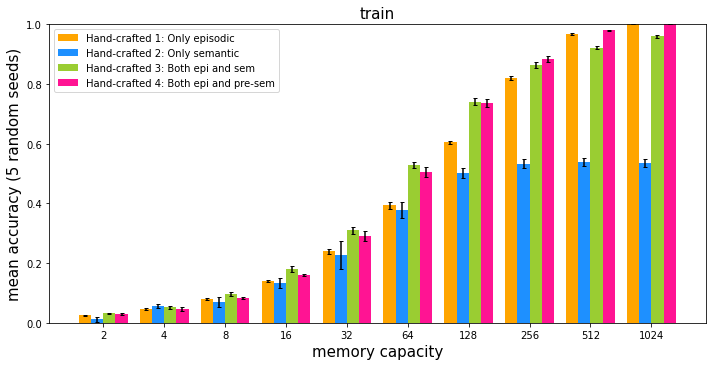

episodic [0.027734375, 0.0482421875, 0.0794921875, 0.1451171875, 0.2458984375, 0.3927734375, 0.5984375, 0.8248046875, 0.9685546875, 1.0]
semantic [0.0150390625, 0.05625, 0.057421875, 0.142578125, 0.2306640625, 0.3794921875, 0.51953125, 0.5419921875, 0.542578125, 0.5396484375]
both [0.028515625, 0.0541015625, 0.0998046875, 0.1830078125, 0.330078125, 0.5458984375, 0.73984375, 0.871875, 0.930859375, 0.9662109375]
both_presem [0.0263671875, 0.0484375, 0.0951171875, 0.164453125, 0.3041015625, 0.5177734375, 0.736328125, 0.8845703125, 0.980859375, 1.0]


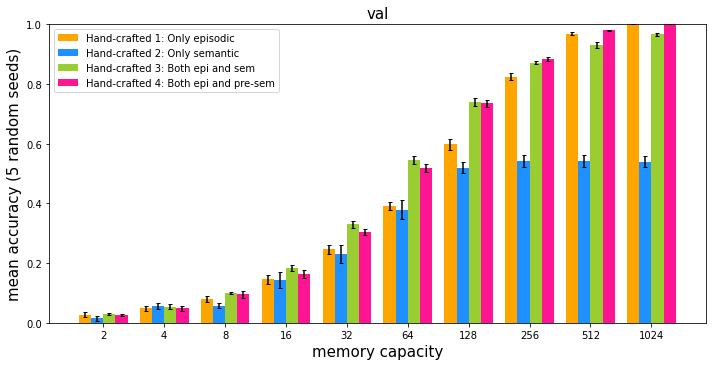

episodic [0.0240234375, 0.04375, 0.0822265625, 0.141796875, 0.2443359375, 0.3935546875, 0.6095703125, 0.818359375, 0.969140625, 1.0]
semantic [0.018359375, 0.0576171875, 0.08046875, 0.1359375, 0.243359375, 0.3884765625, 0.5240234375, 0.5513671875, 0.55078125, 0.551171875]
both [0.0310546875, 0.0544921875, 0.101953125, 0.1912109375, 0.335546875, 0.5572265625, 0.75, 0.86796875, 0.93828125, 0.9650390625]
both_presem [0.0244140625, 0.04609375, 0.0798828125, 0.16484375, 0.2998046875, 0.5162109375, 0.7404296875, 0.8865234375, 0.9814453125, 1.0]


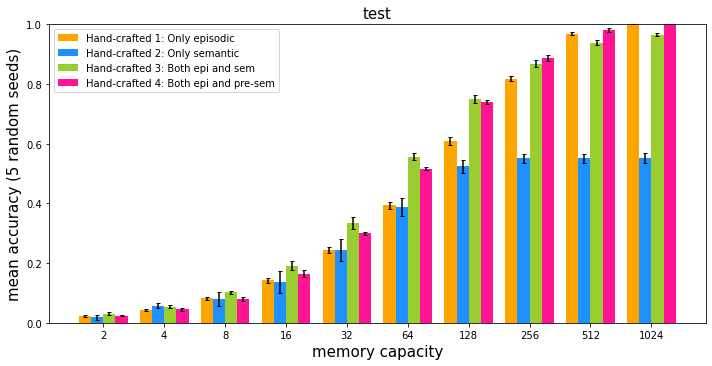

In [6]:
for split in ["train", "val", "test"]:
    capacities = list(results["episodic"])

    fig, ax = plt.subplots(figsize=(10, 5))

    idx = np.asanyarray([i for i in range(len(capacities))])

    width = 0.2

    for memory_type, w, color in zip(memory_order, [-1.5, -0.5, 0.5, 1.5], color_order):
        means = [
            val["means"][split] for key, val in sorted(results[memory_type].items())
        ]
        stds = [val["stds"][split] for key, val in sorted(results[memory_type].items())]

        print(memory_type, means)
        ax.bar(
            x=idx + w * width,
            height=means,
            yerr=stds,
            width=width,
            color=color,
            capsize=2
        )
    ax.set_xticks(idx)
    ax.set_xticklabels(capacities)
    ax.legend(legend_order, fontsize=10, loc="upper left")
    ax.set_xlabel("memory capacity", fontsize=15)
    ax.set_ylabel(f"mean accuracy ({len(seeds)} random seeds)", fontsize=15)

    ax.set_ylim([0, 1])

    fig.tight_layout()
    plt.title(split, fontsize=15)
    plt.savefig("./figures/" + split + "-bar.pdf", bbox_inches="tight")
    plt.show()
